<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Hallucination Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting hallucinations,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [2]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [1]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

/Users/mikeldking/anaconda3/envs/phoenix/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include "halueval_qa_data" from the HaluEval benchmark:

- https://arxiv.org/abs/2305.11747
- https://github.com/RUCAIBox/HaluEval

In [5]:
df = download_benchmark_dataset(
    task="binary-hallucination-classification", dataset_name="halueval_qa_data"
)
df.head()

,reference,query,response,is_hallucination
0,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,no,False
1,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,"Yes, Fuyang and Gaozhou are in the same province.",True
2,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"Billboard"" Hot 100",False
3,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"""808"" peaked at number nine on ""Billboard"" Hot 100.",True
4,"""Arms"" then made a comeback in 2017 reaching #36 on the iTunes chart passing Auli'i Cravalho's ""How Far I'll Go"" from the Disney movie ""Moana"" (2017).Moana ( ) is a 2016 American 3D computer-animated musical fantasy-adventure film produced by Walt Disney Animation Studios and released by Walt Disney Pictures.","Arms is a song by American singer-songwriter Christina Perri, in 2017, it passed Auli'i Cravalho's, ""How Far I'll Go"" from which 2016, American 3D computer-animated Disney movie?",Moana,False


## Display Binary Hallucination Classification Template

View the default template used to classify hallucinations. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(HALLUCINATION_PROMPT_TEMPLATE)


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the answer text
contains factual information and is not a hallucination. A 'hallucination' refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text. Your response should be a single word: either "factual" or "hallucinated", and
it should not include any other text or characters. "hallucinated" indicates that the answer
provides factually inaccurate information to the query based on the reference text. "factual"
indicates that the answer to the question is correct relative to the reference text, and does not
contain made up information. Please re

Template variables:
- **input** : The question or prompt asked on the context data.
- **reference** : The context data used to answer the question
- **output** : The answer generated from the context data, we are checking this answer for halluciations relative to the reference context

## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df = (
    df.sample(n=N_EVAL_SAMPLE_SIZE)
    .reset_index(drop=True)
    .rename(columns={"query": "input", "response": "output"})
)

## LLM Evals: hallucination Classifications GPT-4
Run hallucination against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [10]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [11]:
# The rails fore the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails, concurrency=20
)["label"].tolist()

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:17<00:00 |  6.57it/s



Evaluate the predictions against human-labeled ground-truth hallucination labels.

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:18<00:00 |  5.48it/s

              precision    recall  f1-score   support

hallucinated       0.97      0.70      0.81        46
     factual       0.79      0.98      0.88        54

    accuracy                           0.85       100
   macro avg       0.88      0.84      0.84       100
weighted avg       0.87      0.85      0.85       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

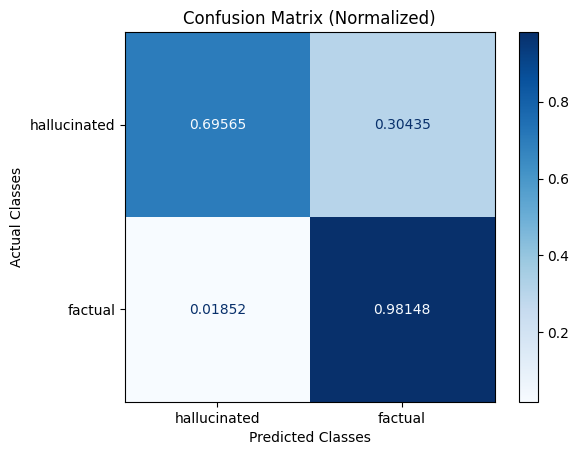

In [12]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for hallucinations, it can be useful to know why the LLM classified a response as a hallucination or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [13]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
hallucination_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the answer text
contains factual information and is not a hallucination. A 'hallucination' refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text.

    [BEGIN DATA]
    ************
    [Query]: {input}
    ************
    [Reference text]: {reference}
    ************
    [Answer]: {output}
    ************
    [END DATA]

    Is the answer above factual or hallucinated based on the query and reference text?

Please read the query, reference text and answer carefully, then write out in a step by step manner
an EXPLANATION to s

llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |██        | 1/5 (20.0%) | ⏳ 00:03<00:14 |  3.67s/it

- Snapped 'factual' to rail: factual


llm_classify |████      | 2/5 (40.0%) | ⏳ 00:04<00:05 |  1.75s/it 

- Snapped 'factual' to rail: factual
- Snapped 'factual' to rail: factual


llm_classify |████████  | 4/5 (80.0%) | ⏳ 00:05<00:01 |  1.10s/it 

- Snapped 'factual' to rail: factual


llm_classify |██████████| 5/5 (100.0%) | ⏳ 00:05<00:00 |  1.14it/s

- Snapped 'factual' to rail: factual


In [14]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, hallucination_classifications_df, left_index=True, right_index=True
)
merged_df[["input", "reference", "output", "is_hallucination", "label", "explanation"]].head()

llm_classify |██████████| 5/5 (100.0%) | ⏳ 00:06<00:00 |  1.38s/it


,input,reference,output,is_hallucination,label,explanation
0,"Caitlin Pike was a character in JAG that was portrayed by an actress who appeared in Pretty Little Liars, and was a dancer in what form of dance?","Commander Caitlin ""Kate"" Pike, USN (JAGC) was a character in the military TV series ""JAG"" and was portrayed by Andrea Parker.Andrea Nicole Parker (born March 8, 1970) is an American television actress and former ballet dancer. She is known for her roles on ""ER"", ""The Pretender"", ""Less than Perfect"", ""Desperate Housewives"", and ""Pretty Little Liars"".",ballet,False,factual,"The query asks about the form of dance that the character Caitlin Pike, portrayed by Andrea Parker, was a dancer in. The reference text mentions that Andrea Parker is a former ballet dancer. Therefore, the answer 'ballet' is based on the information provided in the reference text."
1,"John Lasseter and Mikhail Kalatozov, share which mutual occupation?","John Alan Lasseter (born January 12, 1957) is an American animator, film director, screenwriter, and film producer.Mikhail Konstantinovich Kalatozov (Georgian: მიხეილ კალატოზიშვილი , Russian: Михаи́л Константи́нович Калато́зов ) (28 December 1903 — 27 March 1973), born Mikheil Kalatozishvili, was a Soviet film director of Georgian origin who contributed to both Georgian and Russian cinema.",John Lasseter and Mikhail Kalatozov share the occupation of filmmaking.,True,factual,"The reference text states that John Lasseter is an American animator, film director, screenwriter, and film producer, and Mikhail Kalatozov was a Soviet film director. Both of them are involved in the filmmaking industry. Therefore, the answer that they share the occupation of filmmaking is based on the information provided in the reference text."
2,Lugton and Dunlop are both villages located in what country?,"Lugton is a small village or hamlet in East Ayrshire, Scotland with a population of 80 people.Dunlop ( ; Scots: ""Dunlap"" , Scottish Gaelic: ""Dùn Lùib"" ) is a village and parish in East Ayrshire, Scotland.",Scotland,False,factual,"The query asks for the country where the villages Lugton and Dunlop are located. The reference text clearly states that both Lugton and Dunlop are villages in East Ayrshire, Scotland. Therefore, the answer 'Scotland' is directly supported by the information provided in the reference text."
3,What is the 2010 population of the city to which WRHR-LP was licensed?,"WRHR-LP (95.3 FM) is a radio station licensed to Corbin, Kentucky, USA. As of the 2010 census, the city population was 7,304, with 21,132 living in the ""urban cluster"" that includes Corbin and North Corbin.","7,304",False,factual,"The query asks for the 2010 population of the city to which WRHR-LP was licensed. The reference text states that WRHR-LP is licensed to Corbin, Kentucky, USA and that the 2010 population of Corbin was 7,304. The answer provided is 7,304, which matches the information given in the reference text. Therefore, the answer is not a hallucination, but is factual."
4,What punk rock band using horror film imagery was an influence on the Swedish band Entombed?,"Entombed is a Swedish death metal band formed in 1987 under the name of Nihilist. Entombed have been influenced by bands such as Slayer, Black Sabbath, Celtic Frost, Autopsy, Repulsion, Kiss, The Misfits, Motörhead and Discharge.Misfits are an American punk rock band often recognized as the progenitors of the horror punk subgenre, blending punk and other musical influences with horror film themes and imagery.","The Swedish band Entombed was influenced by American band Misfits, who are recognized as the progenitors of horror punk.",True,factual,"The query asks for the punk rock band that uses horror film imagery and influenced the Swedish band Entombed. The reference text mentions that Entombed was influenced by several bands, including Misfits. The text also states that Misfits is an American punk rock band often recognized as the progenitors of the h

## LLM Evals: hallucination Classifications GPT-3.5
Run hallucination against a subset of the data.

In [15]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [16]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails, concurrency=20
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:19<00:00 |  3.91it/s

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:20<00:00 |  4.91it/s

              precision    recall  f1-score   support

hallucinated       0.82      0.72      0.77        46
     factual       0.78      0.87      0.82        54

    accuracy                           0.80       100
   macro avg       0.80      0.79      0.80       100
weighted avg       0.80      0.80      0.80       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

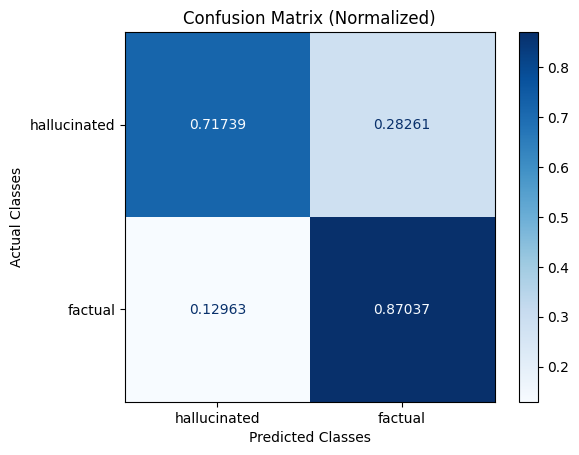

In [17]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [18]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=OpenAIModel(model_name="gpt-4-turbo-preview", temperature=0.0),
    rails=rails,
    concurrency=20,
)["label"].tolist()

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:18<00:00 |  7.60it/s

llm_classify |██████████| 100/100 (100.0%) | ⏳ 00:19<00:00 |  5.03it/s

              precision    recall  f1-score   support

hallucinated       0.92      0.74      0.82        46
     factual       0.81      0.94      0.87        54

    accuracy                           0.85       100
   macro avg       0.86      0.84      0.85       100
weighted avg       0.86      0.85      0.85       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

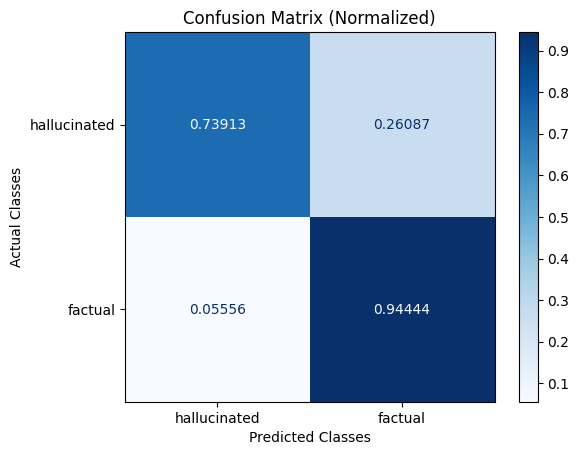

In [19]:
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)